# Проект: Выбор локации для скважины

## О проекте

__Заказчик__: «ГлавРосГосНефть»

__Главная цель исследования__: выбор локации для новой скважины

_Шаги для выбора локации_:
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

__Задачи исследования__:
- Построение модели машинного обучения для определения региона, где добыча принесёт наибольшую прибыль.
- Анализ возможной прибыли и рисков техникой Bootstrap. Выбор региона.

__Описание данных__: 

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

Предоставлены пробы нефти в трёх регионах. 

__Условия задачи__:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

__План выполнения__:
1. Загрузка и подготовка данных.
2. Исследовательский анализ данных.
3. Корреляционный анализ данных.
4. Обучение и проверка модели для каждого региона.
    - Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
    - Обучите модель и сделайте предсказания на валидационной выборке.
    - Сохраните предсказания и правильные ответы на валидационной выборке.
    - Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
    - Проанализируйте результаты.
5. Подготовка к расчёту прибыли:
    - Все ключевые значения для расчётов сохраните в отдельных переменных.
    - Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 
    - Напишите выводы по этапу подготовки расчёта прибыли.
6. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    - Выберите скважины с максимальными значениями предсказаний. 
    - Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
    - Рассчитайте прибыль для полученного объёма сырья.
5. Расчет рисков и прибыли для каждого региона:
    - Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    - Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
    - Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.
6. Вывод.

## Подготовка к проекту

In [ ]:
#!pip install -q phik

In [ ]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import RandomState
import seaborn as sns

import phik
from phik import phik_matrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# константы
TITLE_SIZE = 18
LABEL_SIZE = 16
RANDOM_STATE = 42

## Загрузка и подготовка данных

In [4]:
def show_info(df):
    """
    Функция выводит на экран информацию о датафрейме, а также первые 5 строк датафрейма.
    
    Параметры
    ----------
    df : DataFrame - датафрейм
    """
    display(df.head())
    df.info()

Загрузим данные геологоразведки и изучим информацию о них.

In [ ]:
geo_data_0 = pd.read_csv('/datasets/oil_probes_region_0.csv')

In [ ]:
geo_data_1 = pd.read_csv('/datasets/oil_probes_region_1.csv')

In [ ]:
geo_data_2 = pd.read_csv('/datasets/oil_probes_region_2.csv')

In [8]:
for df in [geo_data_0, geo_data_1, geo_data_2]:
    show_info(df)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Для каждого региона имеется по 100000 записей. Данные соответствуют описанию, пропуски отсутствуют, типы данных определены верно.

Проверим наличие полных дубликатов, а также дубликатов по id скважины.

In [9]:
for df in [geo_data_0, geo_data_1, geo_data_2]:
    print(df.duplicated().sum())

0
0
0


In [10]:
for df in [geo_data_0, geo_data_1, geo_data_2]:
    print(df.duplicated(subset=['id']).sum())

10
4
4


В данных присутствуют дубликаты по ключевому полю id. Удалим их.

In [11]:
geo_data_0 = geo_data_0.drop_duplicates(subset=['id'])
geo_data_1 = geo_data_1.drop_duplicates(subset=['id'])
geo_data_2 = geo_data_2.drop_duplicates(subset=['id'])

In [12]:
# контроль размерности
for df in [geo_data_0, geo_data_1, geo_data_2]:
    print(df.shape[0])

99990
99996
99996


__Промежуточный вывод__:
- Загрузили датасеты, для каждого региона предоставлено по 100000 записей. Данные соответствуют описанию, пропуски отсутствуют, типы данных определены верно.
- Обнаружили и удалили неявные дубликаты в данных по ключевому полю id. Количество записей после удаления дубликатов в  датасетах geo_data_0, geo_data_1, geo_data_2 - 99990, 99996, 99996 записей соответственно.

## Исследовательский анализ данных

In [13]:
def analyze_numerical_data(data, column, title, bins_number=100):
    """
    Функция помогает при проведении статистического анализа количественных признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.
    Может принимать bins для построения графика.

    Выводит для колонки:
    - гистограмму с отмеченным средним значением и медианой
    - диаграмму размаха
    """
     
    median = data[column].median()
    mean = data[column].mean()
        
    # Создаем фигуру и оси для гистограммы
    fig, ax = plt.subplots(2, 1, figsize=(17, 10))

    # Гистограмма
    ax[0].hist(data[column], bins=bins_number, color='skyblue')
    ax[0].set_title(f'Гистограмма для признака "{title}"', fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(True)
    
    ax[0].axvline(median, color='green', linestyle='dashed', linewidth=1.5, label=f'Медиана: {median:.2f}')
    ax[0].axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Среднее: {mean:.2f}')
    ax[0].legend()

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"', fontsize=TITLE_SIZE)
    
    plt.tight_layout()
    # Установка вертикального отступа между графиками
    plt.subplots_adjust(hspace=0.3)
    plt.show()

Проведем __исследовательский анализ__ данных. Все значимые признаки, а также целевой признак, являются непрерывными количественными переменными.

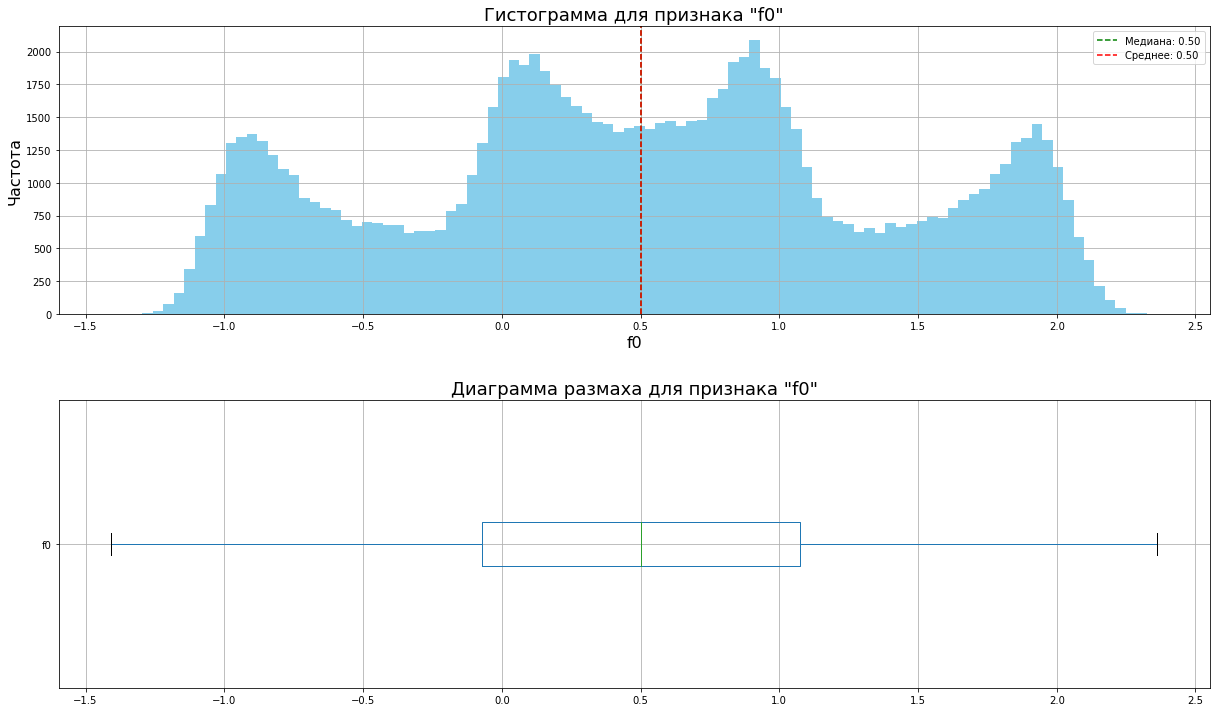

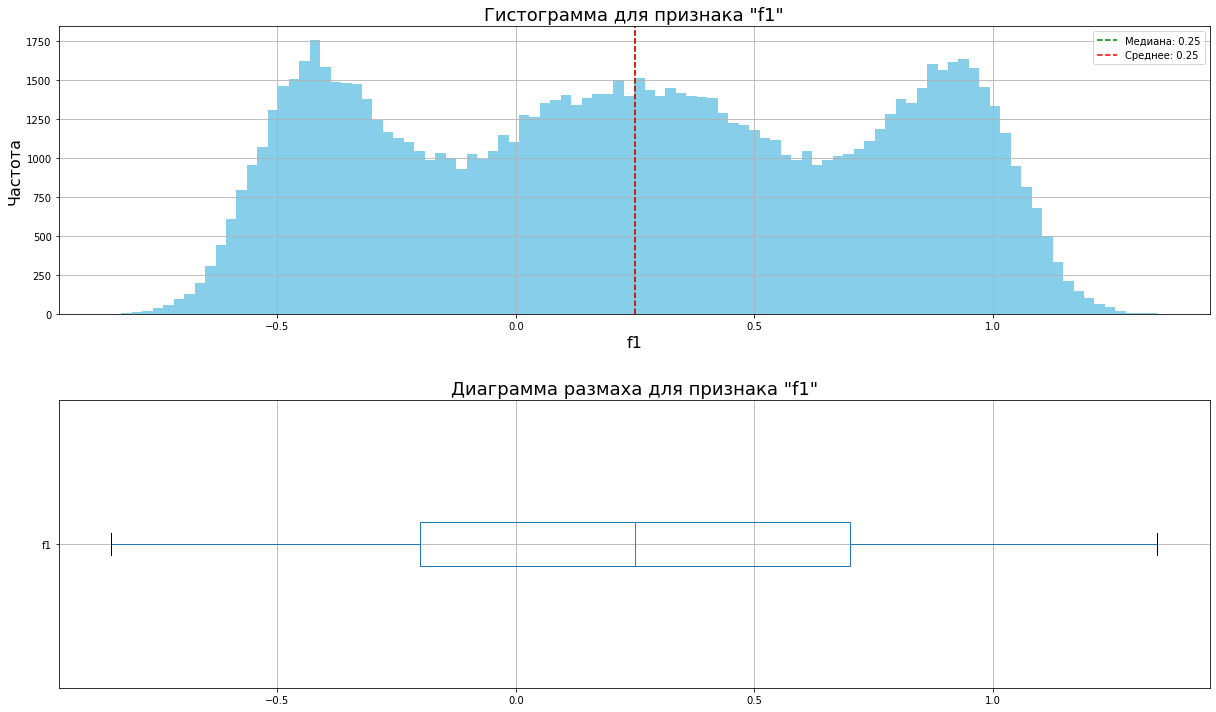

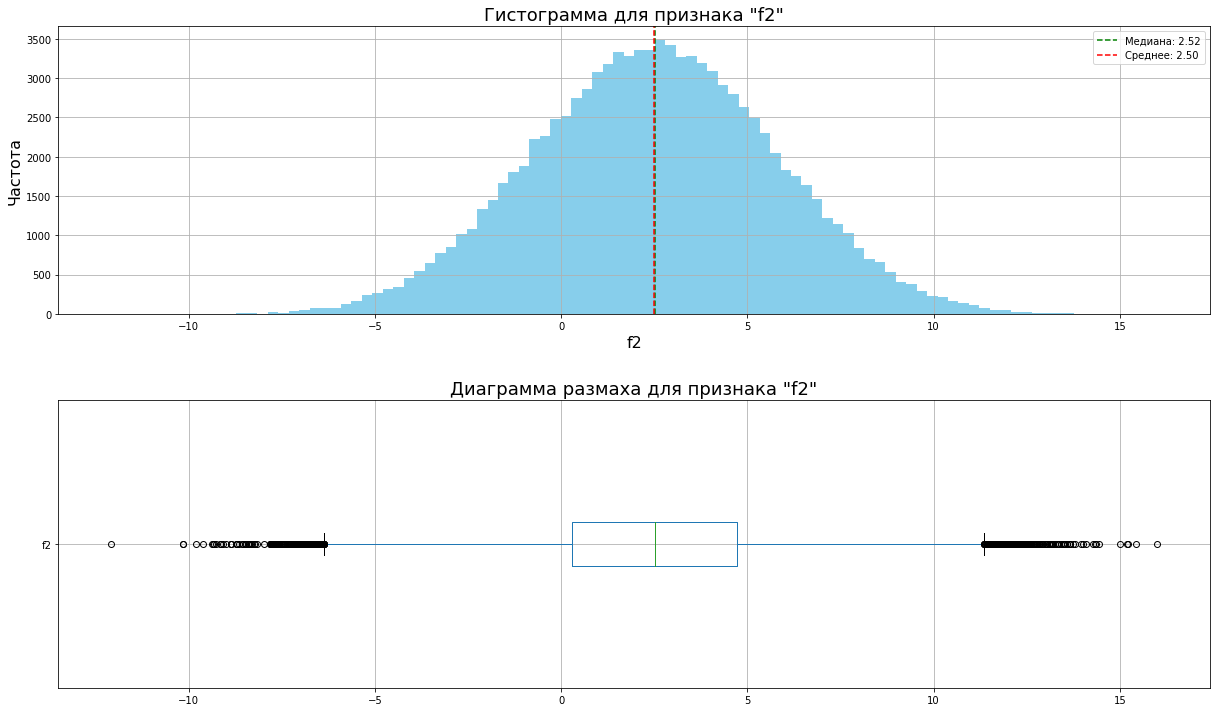

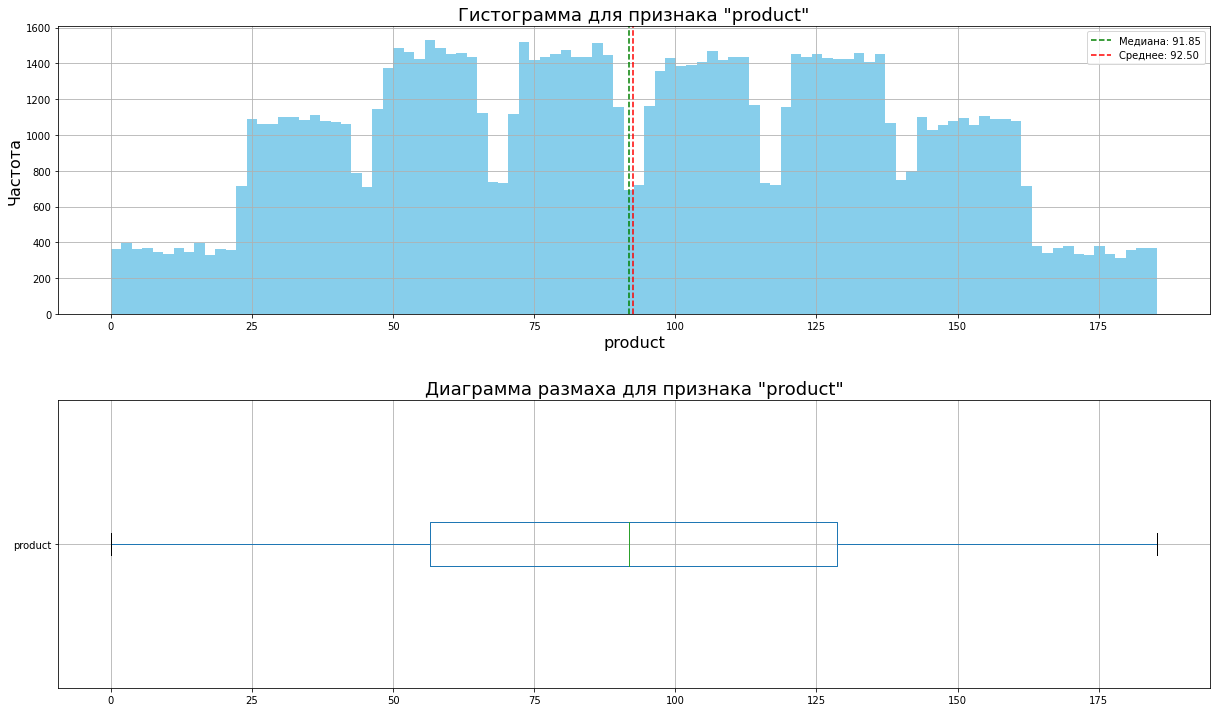

In [14]:
for column in ['f0', 'f1', 'f2', 'product']:
    analyze_numerical_data(geo_data_0, column, column)

In [15]:
display(geo_data_0.describe())

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


Посмотрим на распределение признаков для данных из __geo_data_0__. 

Распределение данных для признака f0 мультимодальное, 4 пика. Значения распределены в диапазоне от -1.41 до 2.36. Границы межквартильного размаха - от -0.07 до 1.07. Медианное и среднее значения - 0.5. Стандартное отклонение - 0.87.  
Распределение данных для признака f1 мультимодальное, 3 пика. Значения распределены в диапазоне от -0.85 до 1.34. Границы межквартильного размаха - от -0.2 до 0.7. Медианное и среднее значения - 0.25. Стандартное отклонение - 0.5. 

Распределение данных для признака f2 имеет форму колокола. Значения распределены в диапазоне от -12.09 до 16. Границы межквартильного размаха - от 0.29 до 4.72. Медианное значение - 2.52, среднее - 2.5. Стандартное отклонение - 3.25. Некоторые значения определены как нетипичные.

Значения признака product распределены в диапазоне от 0 до 185.36. Границы межквартильного размаха - от 56.5 до 128.56. Медианное значение - 91.85, среднее - 92.5. Стандартное отклонение - 44.29. 

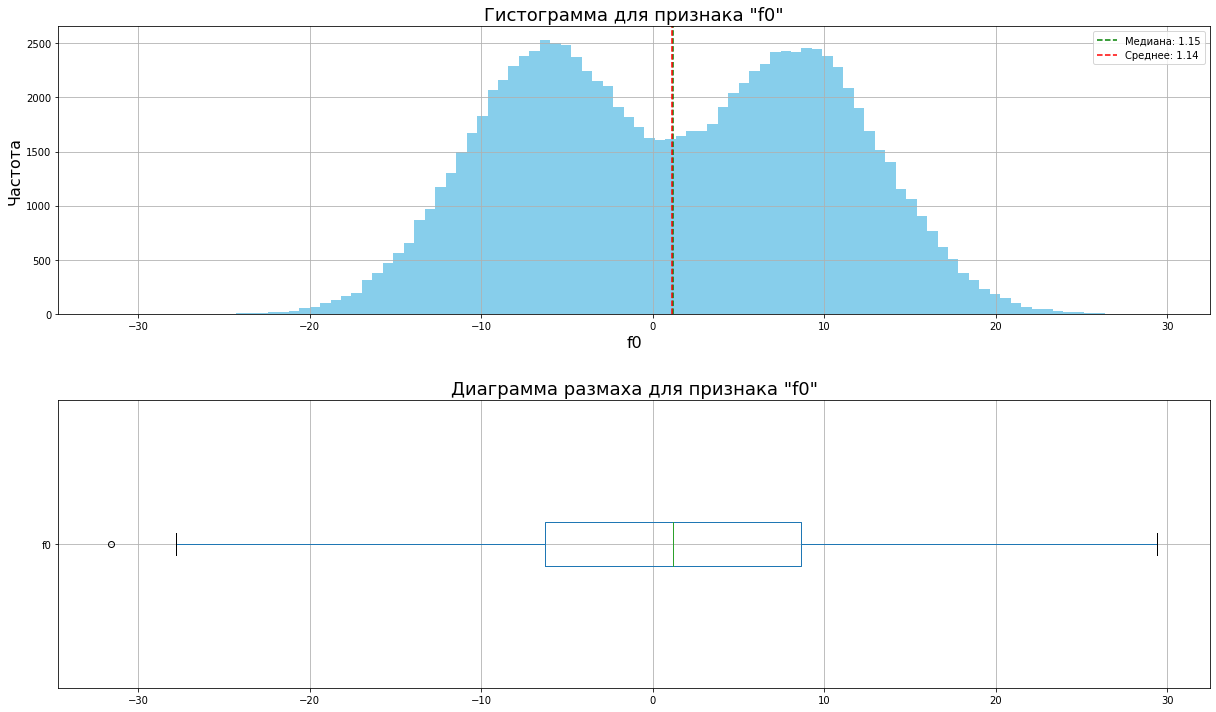

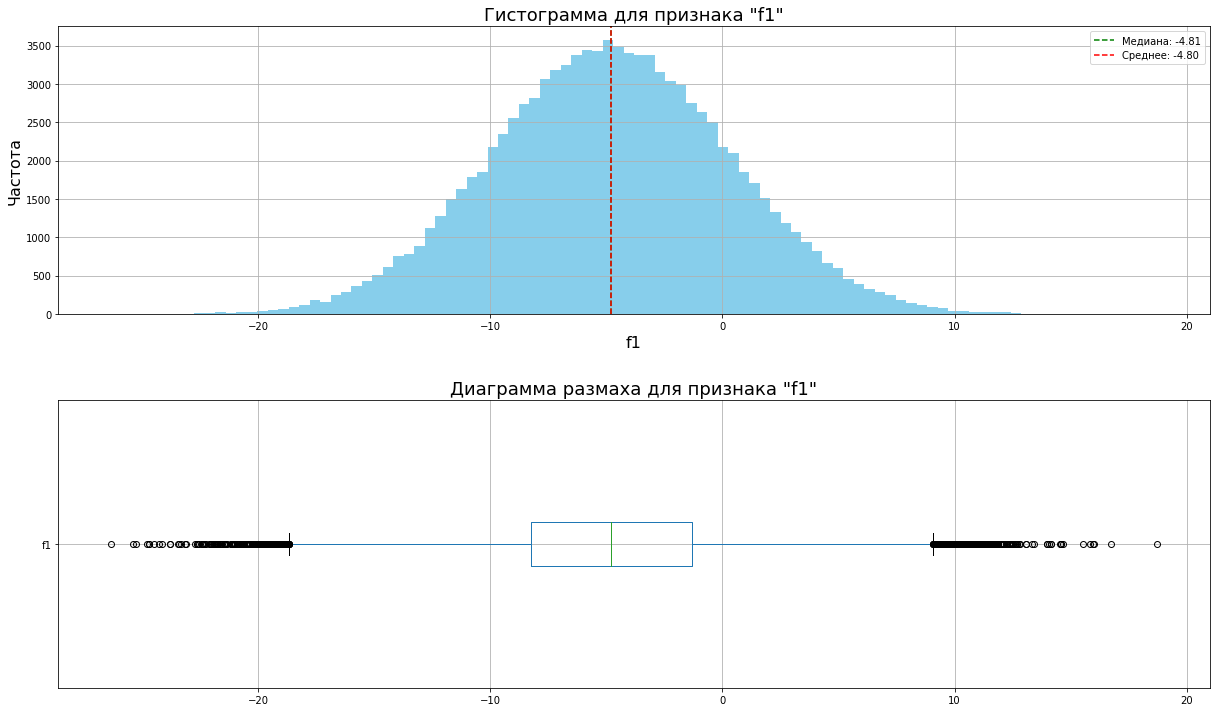

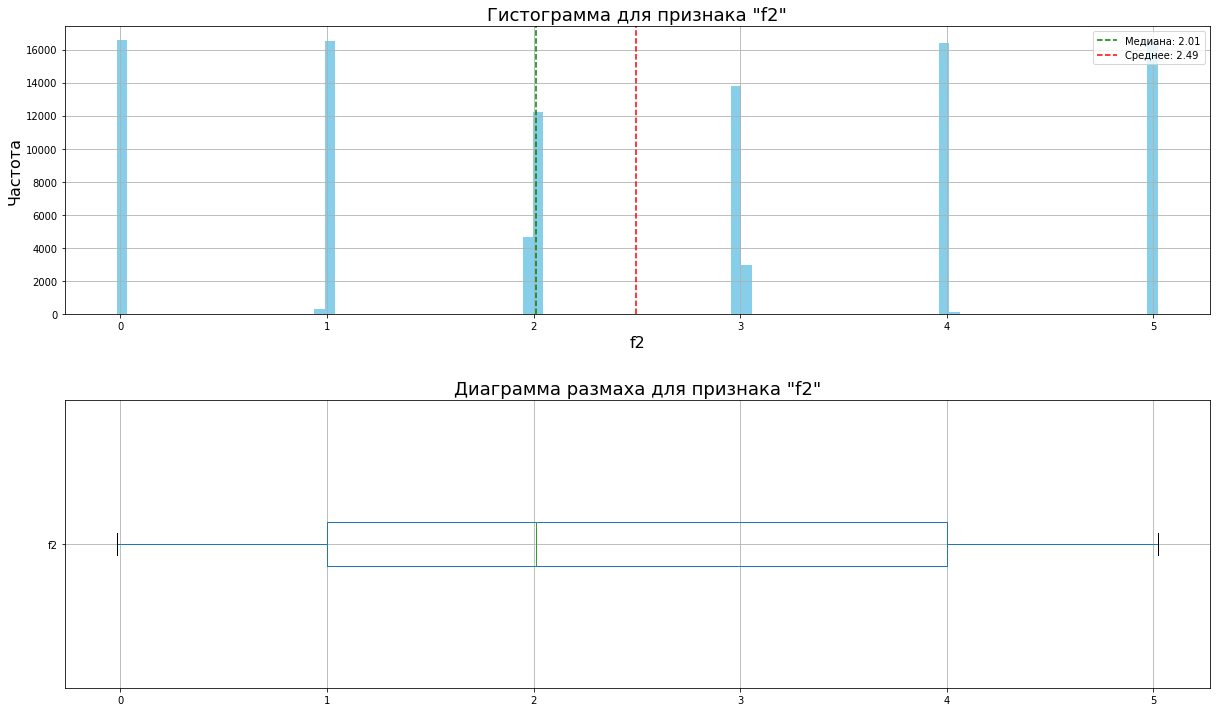

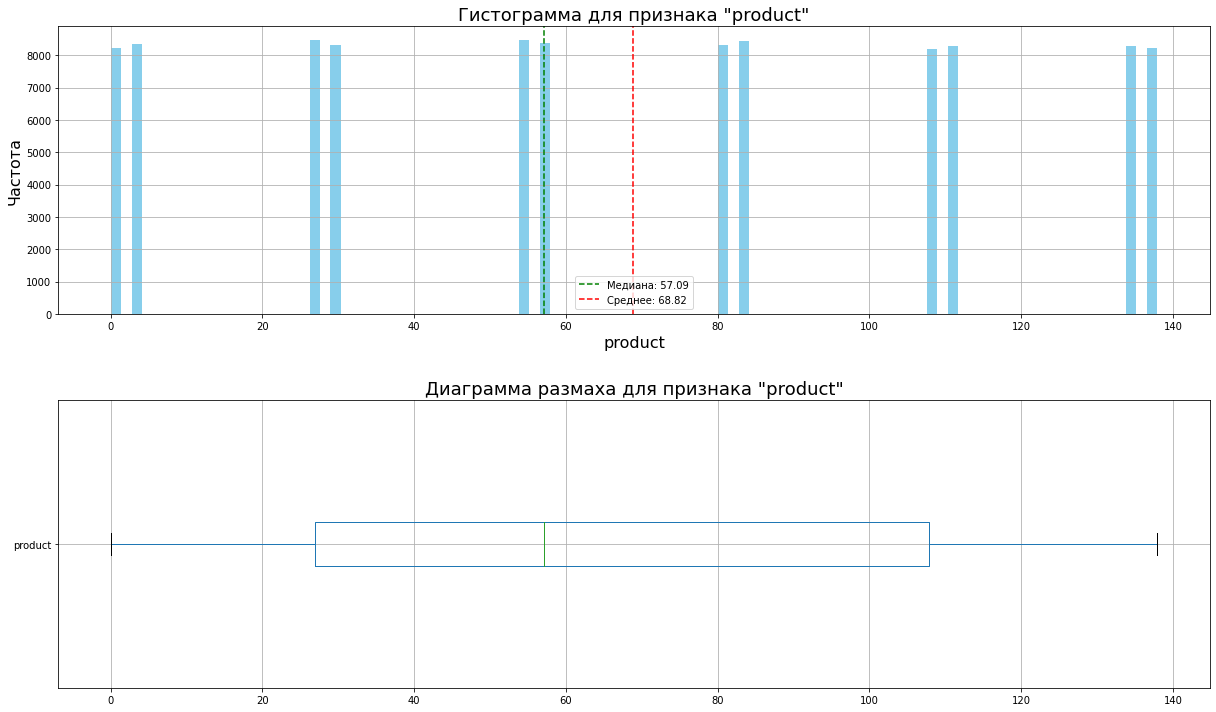

In [16]:
for column in ['f0', 'f1', 'f2', 'product']:
    analyze_numerical_data(geo_data_1, column, column)

In [17]:
display(geo_data_1.describe())

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Распределение признаков для данных из __geo_data_1__. 

Распределение данных для признака f0 бимодальное. Значения распределены в диапазоне от -31.61 до 29.42. Границы межквартильного размаха - от -6.3 до 8.62. Медианное значение - 1.15, среднее - 1.14. Стандартное отклонение - 8.97. Есть нетипичное наблюдение. 

Распределение данных для признака f1 имеет форму колокола. Значения распределены в диапазоне от -26.36 до 18.73. Границы межквартильного размаха - от -8.27 до -1.33. Медианное значение - -4.81, среднее - -4.8. Стандартное отклонение - 5.12. Некоторые значения определены как нетипичные.

Значения признака f2 распределены в диапазоне от -0.02 до 5.02. Границы межквартильного размаха - от 1 до 4. Медианное значение - 2.01, среднее - 2.49. Стандартное отклонение - 1.7. 

Значения признака product распределены в диапазоне от 0 до 137.95. Границы межквартильного размаха - от 26.95 до 107.81. Медианное значение - 57.09, среднее - 68.82. Стандартное отклонение - 45.94. 

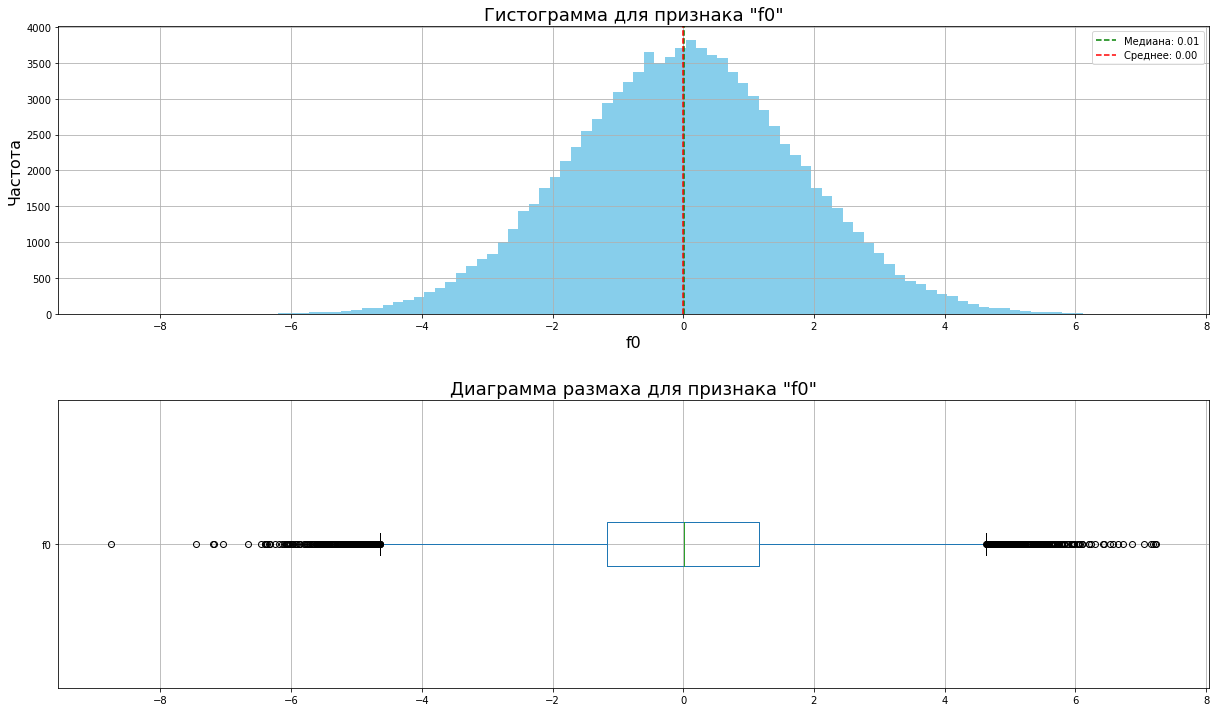

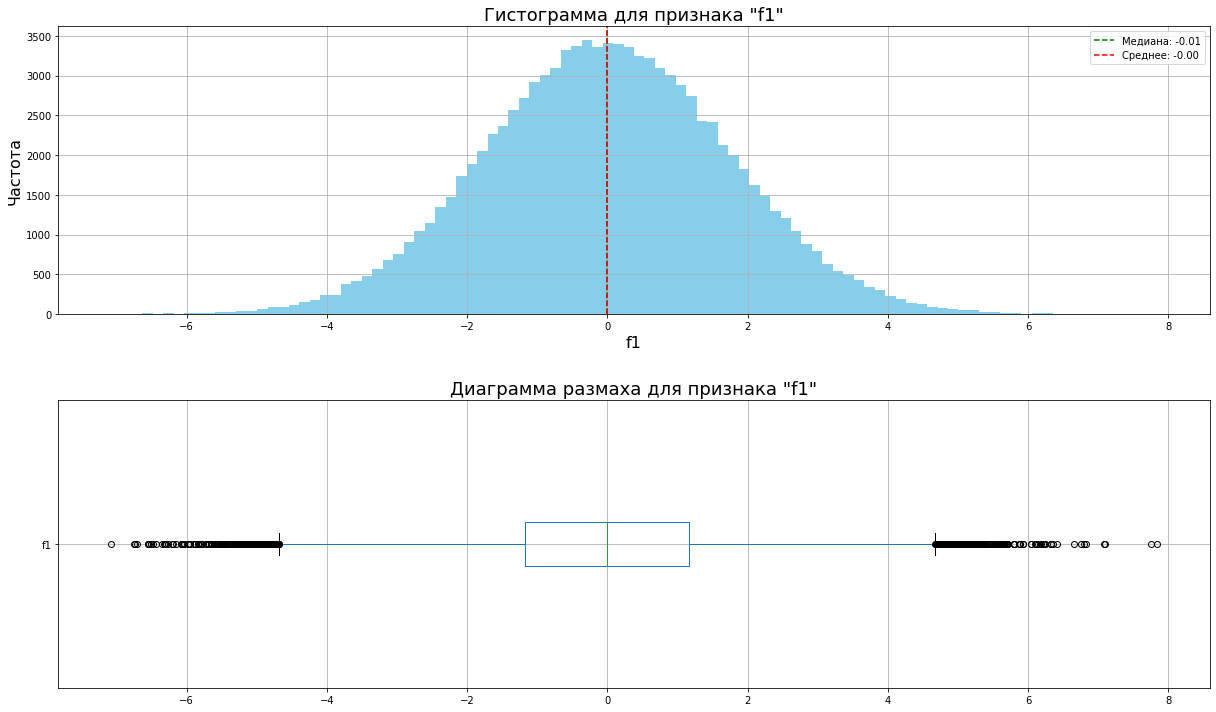

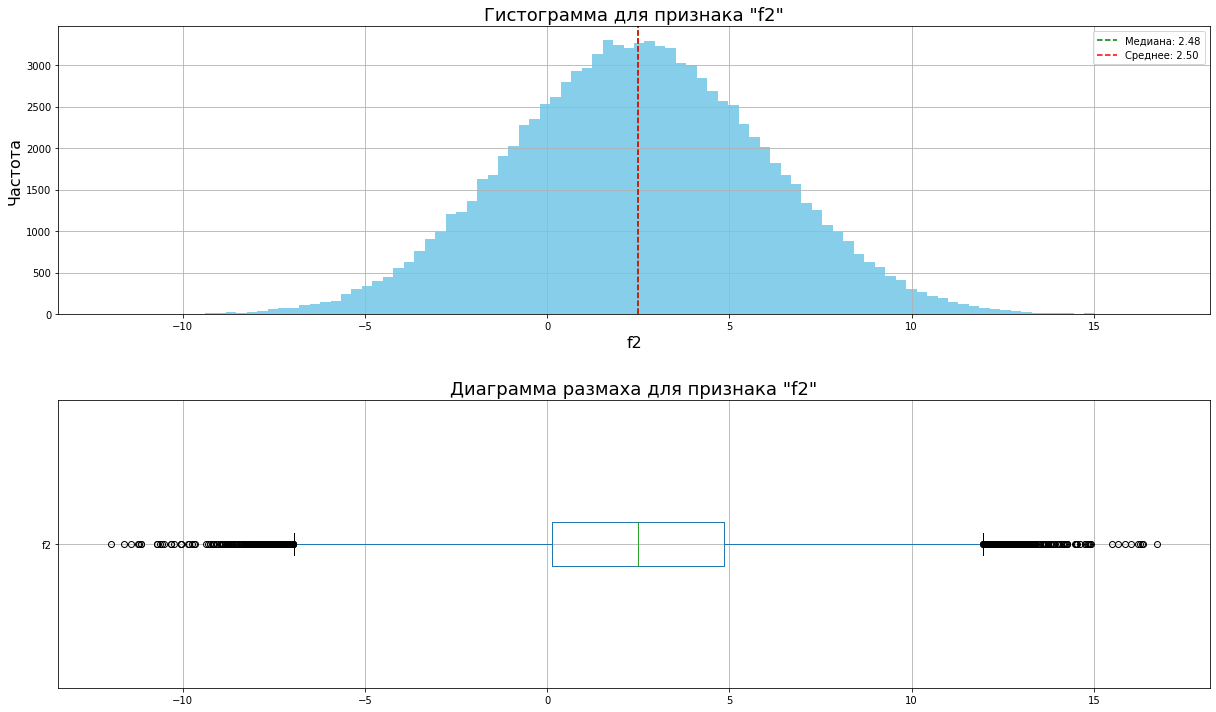

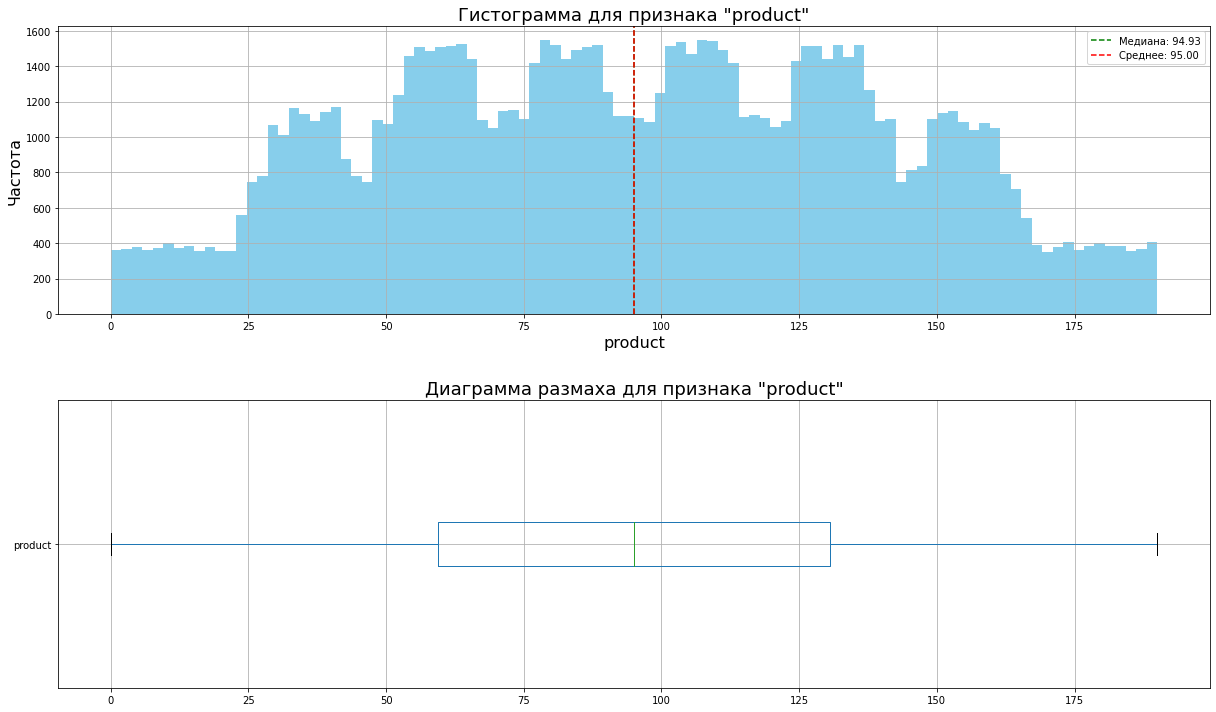

In [18]:
for column in ['f0', 'f1', 'f2', 'product']:
    analyze_numerical_data(geo_data_2, column, column)

In [19]:
display(geo_data_2.describe())

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


Распределение признаков для данных из __geo_data_2__. 

Распределение данных для признака f0 имеет форму колокола. Значения распределены в диапазоне от -8.76 до 7.24. Границы межквартильного размаха - от -1.16 до 1.16. Медианное значение - 0.01, среднее - 0. Стандартное отклонение - 1.73. Некоторые значения определяются как выбросы.

Распределение данных для признака f1 имеет форму колокола. Значения распределены в диапазоне от -7.08 до 7.84. Границы межквартильного размаха - от -1.17 до 1.16. Медианное значение - -0.01, среднее - 0. Стандартное отклонение - 1.73. Некоторые значения определяются как выбросы.

Распределение данных для признака f2 имеет форму колокола. Значения распределены в диапазоне от -11.97 до 16.74. Границы межквартильного размаха - от 0.13 до 4.86. Медианное значение - 2.48, среднее - 2.5. Стандартное отклонение - 3.47. Некоторые значения определяются как выбросы.

Значения признака product распределены в диапазоне от 0 до 190.03. Границы межквартильного размаха - от 59.45 до 130.59. Медианное значение - 94.93, среднее - 95. Стандартное отклонение - 44.75. 

__Промежуточный вывод__:
- провели исследовательский анализ данных;
- выяснили, что наблюдается разный характер распределения признаков в датафреймах. Это подчеркивает необходимость создания разных моделей для каждого из регионов.

## Корреляционный анализ данных

Посмотрим на коллинеарность признаков.

In [20]:
# используем phik для выявления взаимосвязей
phik_matrix(geo_data_0.drop(columns=['id']), interval_cols=['f0', 'f1', 'f2', 'product'])

,f0,f1,f2,product
f0,1.000000,0.762181,0.000000,0.215523
f1,0.762181,1.000000,0.000000,0.253534
f2,0.000000,0.000000,1.000000,0.475867
product,0.215523,0.253534,0.475867,1.000000


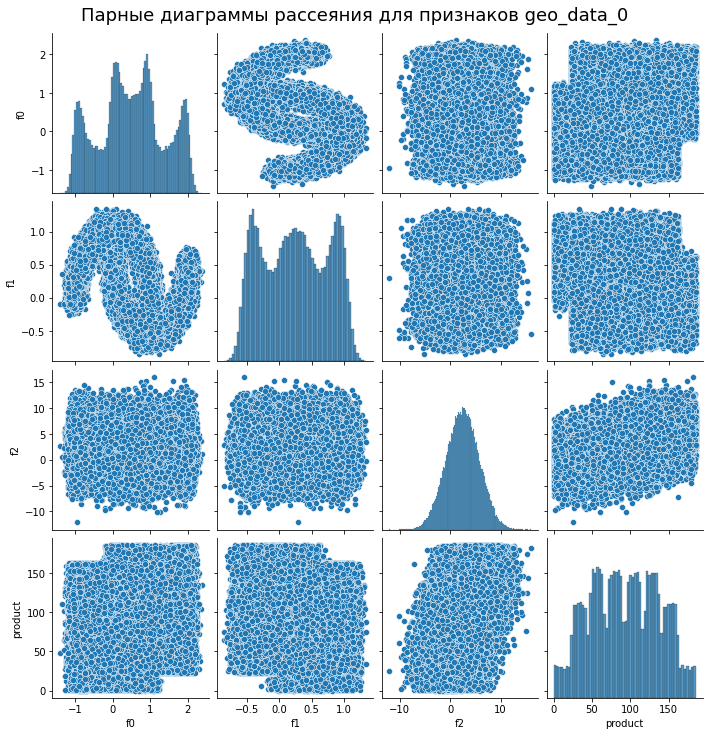

In [21]:
sns.pairplot(geo_data_0.drop(columns=['id']), vars=['f0', 'f1', 'f2', 'product'])
plt.suptitle('Парные диаграммы рассеяния для признаков geo_data_0', fontsize=TITLE_SIZE, y=1.02)
plt.show()

В данных датафрейма __geo_data_0__ видим умеренную взаимосвязь признака product с признаком f2, слабую взаимосвязь с признаками f0, f1. Судя по диаграмме рассеяния - между product и f2 умеренная линейная зависимость, других линейных зависимостей не наблюдается. Мультиколлинеарности между входными признаками нет, однако есть высокая взаимосвязь между признаками f0, f1.

In [22]:
phik_matrix(geo_data_1.drop(columns=['id']), interval_cols=['f0', 'f1', 'f2', 'product'])

,f0,f1,f2,product
f0,1.000000,0.196075,0.000000,0.628477
f1,0.196075,1.000000,0.000000,0.185948
f2,0.000000,0.000000,1.000000,0.978935
product,0.628477,0.185948,0.978935,1.000000


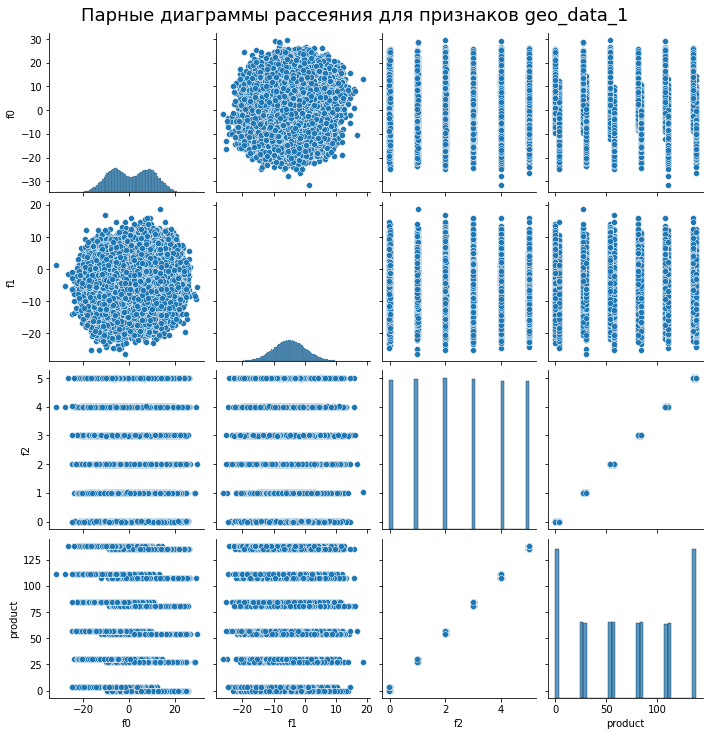

In [23]:
sns.pairplot(geo_data_1.drop(columns=['id']), vars=['f0', 'f1', 'f2', 'product'])
plt.suptitle('Парные диаграммы рассеяния для признаков geo_data_1', fontsize=TITLE_SIZE, y=1.02)
plt.show()

В данных датафрейма __geo_data_1__  очень сильная взаимосвязь признака product и признака f2, заметная с признаком f0, слабая с признаком f1. Явных линейных зависимостей не наблюдается. Мультиколлинеарности между входными признаками нет.

In [24]:
phik_matrix(geo_data_2.drop(columns=['id']), interval_cols=['f0', 'f1', 'f2', 'product'])

,f0,f1,f2,product
f0,1.00000,0.000000,0.000000,0.201070
f1,0.00000,1.000000,0.000000,0.220992
f2,0.00000,0.000000,1.000000,0.443282
product,0.20107,0.220992,0.443282,1.000000


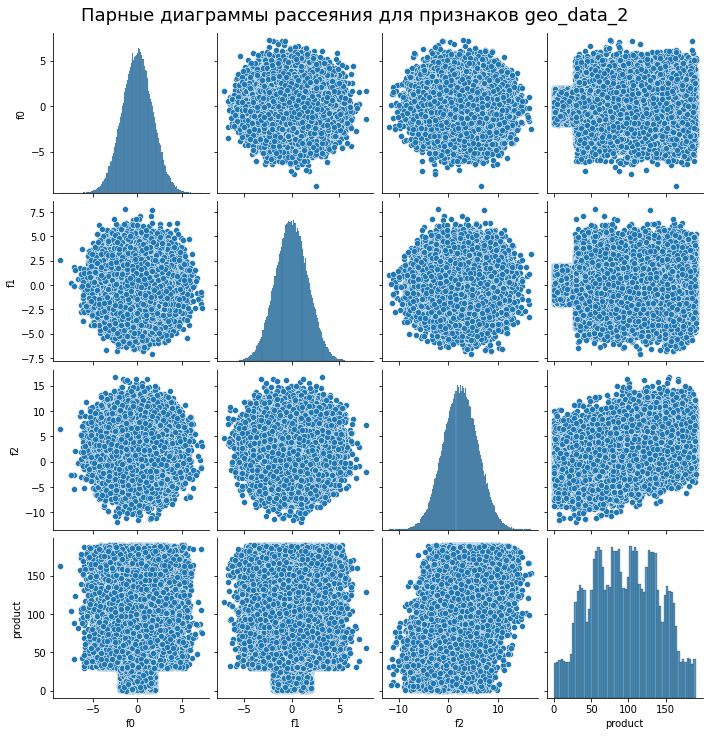

In [25]:
sns.pairplot(geo_data_2.drop(columns=['id']), vars=['f0', 'f1', 'f2', 'product'])
plt.suptitle('Парные диаграммы рассеяния для признаков geo_data_2', fontsize=TITLE_SIZE, y=1.02)
plt.show()

В данных датафрейма __geo_data_3__ умеренная взаимосвязь признака product с признаком f2, слабая с признаками f0 и f1. На диаграмме рассеяния для признаков product и f2 зависимость похожа на умеренную линейную. Других явных линейных зависимостей не наблюдается. Мультиколлинеарности между входными признаками нет.

Мультиколлинеарности между входными признаками в датасетах нет. 

__Промежуточный вывод__:
- изучили корреляцию признаков;
- в данных датафрейма geo_data_0 видим умеренную взаимосвязь признака product с признаком f2, слабую взаимосвязь с признаками f0, f1. Судя по диаграмме рассеяния - между product и f2 умеренная линейная зависимость, других линейных зависимостей не наблюдается.
- в данных датафрейма geo_data_1 очень сильная взаимосвязь признака product и признака f2, заметная с признаком f0, слабая с признаком f1. Явных линейных зависимостей не наблюдается.
- в данных датафрейма geo_data_3 умеренная взаимосвязь признака product с признаком f2, слабая с признаками f0 и f1. На диаграмме рассеяния для признаков product и f2 зависимость похожа на умеренную линейную. Других линейных зависимостей не наблюдается.
- мультиколлинеарности между входными признаками в датасетах нет.

## Обучение и проверка модели

Перед нами задача регресиии, обучение с учителем. Согласно условию, используем для обучения модели только линейную регрессию (остальные — недостаточно предсказуемые).

In [26]:
def train_and_evaluate_model(geo_data):
    """
    Функция создает модель линейной регрессии, 
    обучает ее на полученных данных, возвращает модель и предсказания.
    
    Параметры
    ---------
    geo_data : DataFrame - датафрейм для получения тренирововочной и валидационной выборки
    
    Возвращает
    ---------
    model : LinearRegression - модель линейной регрессии
    results : DataFrame - датафрейм с результатами
    
    """
    
    # готовим данные
    X = geo_data.drop(['id', 'product'], axis=1)
    y = geo_data['product']
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.25, random_state=RANDOM_STATE
    )

    # масштабируем данные
    scaler = StandardScaler()
    num_col_names = X.select_dtypes(exclude=['object']).columns
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=num_col_names)
    X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=num_col_names)

    # обучаем модель
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # делаем прогнозы
    predictions = model.predict(X_valid_scaled)
    
    # формируем датафрейм с результатами
    results = pd.DataFrame({'y_valid': y_valid, 'predictions': predictions})
    
    return model, results

In [27]:
def get_residuals_diagrams(results):
    """
    Построение графиков распределения остатков и дисперсии остатков.

    Параметры
    ---------
    results : DataFrame - датафрейм с реальными значениями и предсказаниями
    """

    # Рассчитываем остатки
    residuals = results['y_valid'] - results['predictions']
    
    # Вычисляем среднее значение остатков
    mean_residual = residuals.mean()

    # Строим гистограмму частотности и диаграмму рассеяния
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Гистограмма остатков
    axes[0].hist(residuals, bins=30, color='skyblue', edgecolor='black')
    axes[0].axvline(mean_residual, color='blue', linestyle='--', label=f'Среднее: {mean_residual:.2f}')
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Частота')
    axes[0].legend()

    # Диаграмма рассеяния остатков
    axes[1].scatter(results['predictions'], residuals, alpha=0.7, color='orange')
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')

    plt.tight_layout()
    plt.show()

Обучим модели для каждого региона, получим предсказания и значения метрики RMSE. 

Средний запас предсказанного сырья для 1 региона: 92.60984027552017
RMSE модели 1: 37.68508926201444


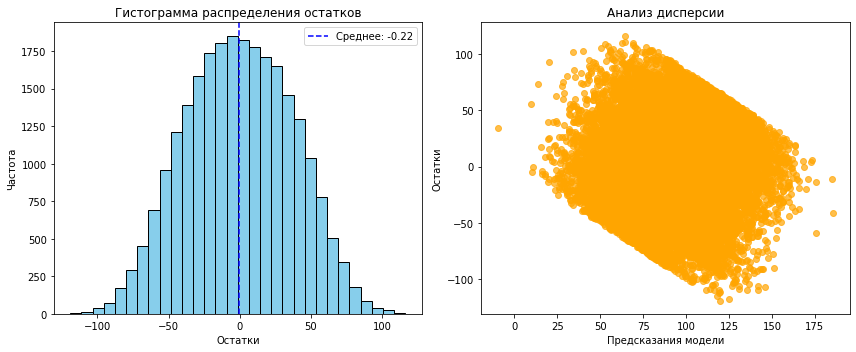

Средний запас предсказанного сырья для 2 региона: 68.57703454115173
RMSE модели 2: 0.8928265978121422


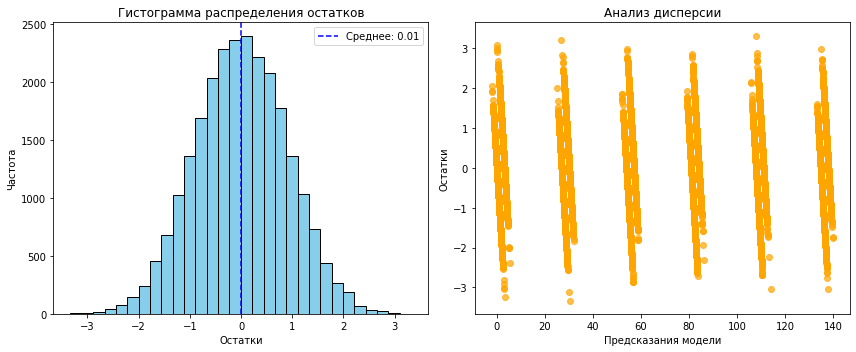

Средний запас предсказанного сырья для 3 региона: 94.93478722287514
RMSE модели 3: 40.080822438088305


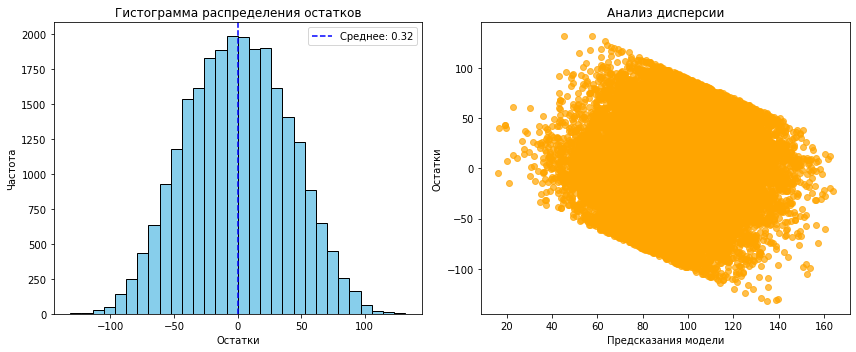

In [28]:
model_1, results_model_1 = train_and_evaluate_model(geo_data_0)
model_2, results_model_2 = train_and_evaluate_model(geo_data_1)
model_3, results_model_3 = train_and_evaluate_model(geo_data_2)

for i, results in enumerate([results_model_1, results_model_2, results_model_3], start=1):
    print(f'Средний запас предсказанного сырья для {i} региона: {results["predictions"].mean()}')
    print(f'RMSE модели {i}: {mean_squared_error(results["y_valid"], results["predictions"], squared=False)}')
    get_residuals_diagrams(results)

Проанализируем результаты.

Для 1 модели - средний запас предсказанного сырья 92.61, значение RMSE равно 37.69.
Для 2 модели - средний запас предсказанного сырья 68.58, значение RMSE равно 0.89.
Для 3 модели - средний запас предсказанного сырья 94.93, значение RMSE равно 40.08.

Вторая модель имеет более низкий показатель RMSE и дает более точные прогнозы. Вместе с тем, в этом регионе предсказаны не такие большие запасы сырья.

Предсказанные запасы в двух других регионах больше, однако модели имеют довольно большое значение RMSE (можем сравнить со средними значениями запасов), что указывает на проблемы с точностью.

Визуально остатки всех трех моделей имеют нормальное несмещенное распределение, среднее близко к нулю. Но вместе с тем мы не наблюдаем устойчивости остатков модели. Это означает, что модель упускает какие-то закономерности. Т.к. в наших моделях только три входных признака, возможно, этого не достаточно для качественных предсказаний, и нужно увеличить их количество.

__Промежуточный вывод__:
- создали модели для каждого региона, обучили их и сделали прогнозы;
- получили значения метрики RMSE для каждой модели;
- оценили качество моделей.

## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [29]:
# Общее количество исследованных точек
NUMBER_POINTS_INVESTIGATED = 500

# Количество выбранных для разработки
NUMBER_POINTS_SELECTED = 200

# Бюджет на разработку в рублях
BUDGET = 10e9

# Доход с каждой единицы продукта (с 1000 баррелей)
REVENUE_PER_1000_BARRELS = 450_000

# общий достаточный объём сырья (в тысячах баррелей)
sufficient_number_of_thousand_barrels = BUDGET / REVENUE_PER_1000_BARRELS

# достаточный объём сырья для безубыточной разработки новой скважины
sufficient_number_of_thousand_barrels_per_point = sufficient_number_of_thousand_barrels / NUMBER_POINTS_SELECTED

print("Достаточный объем сырья для одной точки (в тысячах баррелей):",
       f'{sufficient_number_of_thousand_barrels_per_point:.2f}')

Достаточный объем сырья для одной точки (в тысячах баррелей): 111.11


Если мы посмотрим на средние запасы предсказанного сырья для каждого региона (92.61, 68.58, 94.93), то они ниже рассчитанного значения достаточного объема сырья для безубыточной разработки одной точки. При этом ошибка модели RMSE для второго региона минимальна, т.е. этот регион вызывает наибольшие опасения для безубыточной разработки новой скважины. 

__Промежуточный вывод__:
- учитывая условия, рассчитали значения достаточного объема сырья для безубыточной разработки одной точки;
- средние запасы предсказанного сырья для каждого региона оказались ниже рассчитанного значения, выбор второго региона кажется наиболее рискованным.

## Расчёт прибыли и рисков 

In [30]:
def calculate_profit(results, selected_points, revenue_per_1000_barrels, budget):
    """
    Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели.
    
    Параметры
    ---------
    results : DataFrame - датафрейм с реальными значениями и предсказаниями
    selected_points : int - количество выбранных для разработки скважин
    revenue_per_1000_barrels : float - доход, получаемый за 1000 баррелей
    budget : float - бюджет, потраченный на разработку
    
    Возвращает
    -------
    float - общая прибыль от выбранных скважин
    """
    
    # если количество точек <= 0, прибыль 0
    if selected_points <= 0:
        return 0  
    
    # максимальное число точек - размер выборки
    if selected_points > len(results):
        selected_points = len(results)  
        
    indexes_of_best_points = results['predictions'].nlargest(selected_points).index
    number_of_thousand_barrels = results.loc[indexes_of_best_points, 'y_valid'].sum()
   
    return number_of_thousand_barrels * revenue_per_1000_barrels - budget

Рассчитаем риски и прибыль по каждому из регионов, используя наши модели.

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [31]:
state = RandomState(12345) 
bootstrap_number = 1000

for i, results in enumerate([results_model_1, results_model_2, results_model_3], start=1):
    profit = []
    for j in range(bootstrap_number):
        subsample = results.sample(n=NUMBER_POINTS_INVESTIGATED, replace=True, random_state=state)
        profit.append(calculate_profit(subsample, NUMBER_POINTS_SELECTED, REVENUE_PER_1000_BARRELS, BUDGET))
    profit = pd.Series(profit)
    print(f'Регион {i}:')
    print(f'Средняя прибыль: {profit.mean():,.2f}')
    print(f'95%-ый доверительный интервал: ({profit.quantile(0.025):,.2f} - {profit.quantile(0.975):,.2f})')
    print(f'Риск убытков:{(profit < 0).mean()*100}%')
    print()

Регион 1:
Средняя прибыль: 629,742,231.94
95%-ый доверительный интервал: (5,819,895.00 - 1,266,924,619.72)
Риск убытков:2.5%

Регион 2:
Средняя прибыль: 642,136,308.20
95%-ый доверительный интервал: (169,201,556.24 - 1,151,282,496.82)
Риск убытков:0.3%

Регион 3:
Средняя прибыль: 561,816,590.55
95%-ый доверительный интервал: (-75,327,539.15 - 1,206,432,286.44)
Риск убытков:4.2%



Согласно условию задачи, после оценки рисков нам нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбрать регион с наибольшей средней прибылью.

Риск убытков меньше 2.5% только при разработке скважин во втором регионе, для него же получено наибольшее значение средней прибыли. Выбор других регионов для разработки слишком рискованный. 

__Промежуточный вывод__:
- рассчитали средную прибыль для каждого региона и риски убытков с использованием бутстрепа;
- только при выборе второго региона риск убытков меньше 2.5% и составляет 0.3%. Средняя прибыль при выборе второго региона составляет 642 136 308.20 руб.
- рекомендуем второй регион для разработки скважин.

## Вывод

Мы работали с информацией о характеристиках нефти в скважинах, расположенных в трех регионах. Целью проекта было определение региона для разработки скважин.

Мы __загрузили датасеты__, для каждого региона было предоставлено по 100000 записей. Данные соответствовали описанию.
Обнаружили и удалили неявные дубликаты в данных по ключевому полю id. Количество записей после удаления дубликатов в датасетах geo_data_0, geo_data_1, geo_data_2 - 99990, 99996, 99996 записей соответственно

Провели __исследовательский анализ данных__. Разный характер распределения признаков в датафреймах подчеркивает необходимость создания разных моделей для каждого из регионов.

Распределение признаков для данных из __geo_data_0__:
- Распределение данных для признака f0 мультимодальное, 4 пика. Значения распределены в диапазоне от -1.41 до 2.36. Границы межквартильного размаха - от -0.07 до 1.07. Медианное и среднее значения - 0.5. Стандартное отклонение - 0.87. - Распределение данных для признака f1 мультимодальное, 3 пика. Значения распределены в диапазоне от -0.85 до 1.34. Границы межквартильного размаха - от -0.2 до 0.7. Медианное и среднее значения - 0.25. Стандартное отклонение - 0.5. 
- Распределение данных для признака f2 имеет форму колокола. Значения распределены в диапазоне от -12.09 до 16. Границы межквартильного размаха - от 0.29 до 4.72. Медианное значение - 2.52, среднее - 2.5. Стандартное отклонение - 3.25. Некоторые значения определены как нетипичные.
- Значения признака product распределены в диапазоне от 0 до 185.36. Границы межквартильного размаха - от 56.5 до 128.56. Медианное значение - 91.85, среднее - 92.5. Стандартное отклонение - 44.29. 

Распределение признаков для данных из __geo_data_1__:
- Распределение данных для признака f0 бимодальное. Значения распределены в диапазоне от -31.61 до 29.42. Границы межквартильного размаха - от -6.3 до 8.62. Медианное значение - 1.15, среднее - 1.14. Стандартное отклонение - 8.97. Есть нетипичное наблюдение. 
- Распределение данных для признака f1 имеет форму колокола. Значения распределены в диапазоне от -26.36 до 18.73. Границы межквартильного размаха - от -8.27 до -1.33. Медианное значение - -4.81, среднее - -4.8. Стандартное отклонение - 5.12. Некоторые значения определены как нетипичные.
- Значения признака f2 распределены в диапазоне от -0.02 до 5.02. Границы межквартильного размаха - от 1 до 4. Медианное значение - 2.01, среднее - 2.49. Стандартное отклонение - 1.7. 
- Значения признака product распределены в диапазоне от 0 до 137.95. Границы межквартильного размаха - от 26.95 до 107.81. Медианное значение - 57.09, среднее - 68.82. Стандартное отклонение - 45.94. 

Распределение признаков для данных из __geo_data_2__. 
- Распределение данных для признака f0 имеет форму колокола. Значения распределены в диапазоне от -8.76 до 7.24. Границы межквартильного размаха - от -1.16 до 1.16. Медианное значение - 0.01, среднее - 0. Стандартное отклонение - 1.73. Некоторые значения определяются как выбросы.
- Распределение данных для признака f1 имеет форму колокола. Значения распределены в диапазоне от -7.08 до 7.84. Границы межквартильного размаха - от -1.17 до 1.16. Медианное значение - -0.01, среднее - 0. Стандартное отклонение - 1.73. Некоторые значения определяются как выбросы.
- Распределение данных для признака f2 имеет форму колокола. Значения распределены в диапазоне от -11.97 до 16.74. Границы межквартильного размаха - от 0.13 до 4.86. Медианное значение - 2.48, среднее - 2.5. Стандартное отклонение - 3.47. Некоторые значения определяются как выбросы.
- Значения признака product распределены в диапазоне от 0 до 190.03. Границы межквартильного размаха - от 59.45 до 130.59. Медианное значение - 94.93, среднее - 95. Стандартное отклонение - 44.75. 

Мы провели __корреляционный анализ данных__. В данных датафрейма __geo_data_0__ видим умеренную взаимосвязь признака product с признаком f2, слабую взаимосвязь с признаками f0, f1. Судя по диаграмме рассеяния - между product и f2 умеренная линейная зависимость, других линейных зависимостей не наблюдается. В данных датафрейма __geo_data_1__ очень сильная взаимосвязь признака product и признака f2, заметная с признаком f0, слабая с признаком f1. Явных линейных зависимостей не наблюдается. В данных датафрейма __geo_data_3__ умеренная взаимосвязь признака product с признаком f2, слабая с признаками f0 и f1. На диаграмме рассеяния для признаков product и f2 зависимость похожа на умеренную линейную. Других линейных зависимостей не наблюдается. Мультиколлинеарности между входными признаками в датасетах нет.

Мы решали задачу регресиии, обучение с учителем. Согласно условию, использовали линейную регрессию. Мы __создали модели__ для каждого региона, __обучили их и сделали прогнозы__. Для 1 модели (1 регион) средний запас предсказанного сырья - 92.61 тыс.баррелей, значение RMSE равно 37.69 тыс.баррелей. Для 2 модели (2 регион) средний запас предсказанного сырья - 68.58 тыс.баррелей, значение RMSE равно 0.89. Для 3 модели (3 регион) средний запас предсказанного сырья - 94.93 тыс.баррелей, значение RMSE равно 40.08 тыс.баррелей.

Вторая модель имеет более низкий показатель RMSE и дает более точные прогнозы. Вместе с тем, в этом регионе предсказаны не такие большие запасы сырья. Предсказанные запасы в двух других регионах больше, однако модели имеют довольно большое значение RMSE (можем сравнить со средними значениями запасов), что указывает на проблемы с точностью. Визуально остатки всех трех моделей имеют нормальное несмещенное распределение, среднее близко к нулю, но не наблюдается устойчивости остатков модели. Т.к. в наших моделях только три входных признака, возможно, этого не достаточно для качественных предсказаний, и мы можем рекомендовать попробовать увеличить их количество.

Далее мы рассчитали значения достаточного объема сырья для безубыточной разработки одной точки. Средние запасы предсказанного сырья для каждого региона оказались ниже рассчитанного значения, выбор второго региона кажется наиболее рискованным.

С использованием Bootstrap с 1000 выборок мы нашли распределение прибыли для каждого региона, среднюю прибыль, 95%-й доверительный интервал и риск убытков. Только при выборе второго региона риск убытков меньше 2.5% и при этом по расчетам получена наибольшая средняя прибыль. __Рекомендуем второй регион__ для разработки новой скважины:
- средняя прибыль: 642,136,308.20 руб.
- 95%-ый доверительный интервал: (169,201,556.24 - 1,151,282,496.82)
- риск убытков:0.3%.